In [1]:
import numpy as np
from xrdc import xrdutils as xdu
from xrdc import simulation
from xrdc import datasets as xd
import matplotlib.pyplot as plt

from siamese_xrd import train, datasets, utils

def sample_peak_intensity():
    return np.random.uniform()

In [2]:
from pymatgen.core.lattice import Lattice
from pymatgen.core.structure import Structure
from pymatgen.analysis.diffraction.xrd import XRDCalculator

In [3]:
# FCC Ni definition
lparam_Ni = 3.52
s = Structure.from_spacegroup("Fm-3m", Lattice.cubic(lparam_Ni), ["Ni"],
                                 [[0, 0, 0]])
s

Structure Summary
Lattice
    abc : 3.52 3.52 3.52
 angles : 90.0 90.0 90.0
 volume : 43.614208
      A : 3.52 0.0 0.0
      B : 0.0 3.52 0.0
      C : 0.0 0.0 3.52
PeriodicSite: Ni (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Ni (0.0000, 1.7600, 1.7600) [0.0000, 0.5000, 0.5000]
PeriodicSite: Ni (1.7600, 0.0000, 1.7600) [0.5000, 0.0000, 0.5000]
PeriodicSite: Ni (1.7600, 1.7600, 0.0000) [0.5000, 0.5000, 0.0000]

In [4]:
gen = XRDCalculator("CuKa")
# gen = XRDCalculator(1.54)
pat = gen.get_pattern(s)
xdu.to_q(pat.x), pat.y

(array([3.09170346, 3.56999165, 5.04873061]),
 array([100.        ,  46.36686035,  26.67333336]))

Define the same structure directly from lattice vectors and unit cell

In [5]:
lat = Lattice(lparam_Ni * np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]))
fcc_basis = np.array(((0, 0, 0), (.5, .5, 0), (.5, 0, .5), (0, .5, .5)))
struct = Structure(lat, ["Ni"] * len(fcc_basis), fcc_basis)

pat = gen.get_pattern(struct)
q, i = xdu.to_q(pat.x), pat.y

In [6]:
def xrd_from_geo(lattice, basis, species):
    lat = Lattice(lattice)
    struct = Structure(lat, species, basis)
    
    pat = gen.get_pattern(struct)
    return xdu.to_q(pat.x), pat.y

In [7]:
def distort_Ni(relative_c, common_scale = 1.):
    return xrd_from_geo((lparam_Ni * common_scale) * np.array([[1, 0, 0], [0, 1, 0], [0, 0, relative_c]]), fcc_basis, ["Ni"] * 4)

In [8]:
def Ni_cubic_to_tetra(N, c_start, c_end, sigma = .01):
    """
    """
    cs =  np.linspace(c_start, c_end, N)
    res = []
    ordinal = []
    for c in cs:
        q, i = distort_Ni(c)
        qq, ii = xdu.mk_pattern(i, q, sigma, with_grid=True)
        ordinal.append(np.vstack([q, i]))
        res.append(ii)
    return ordinal, np.vstack(res)

def Ni_cubic_scale(N, s_start, s_end, sigma = .01):
    """
    """
    ss =  np.linspace(s_start, s_end, N)
    res = []
    ordinal = []
    for c in ss:
        q, i = distort_Ni(1, c)
        qq, ii = xdu.mk_pattern(i, q, sigma, with_grid=True)
        ordinal.append(np.vstack([q, i]))
        res.append(ii)
    return ordinal, np.vstack(res)

In [9]:
#TODO refactor

def Ni_tetra_random(N, cmin, cmax, scalemin, scalemax, sigma = .01):
    """
    """
    cs = cmin + np.random.uniform(size = N) * (cmax - cmin)
    scales = scalemin + np.random.uniform(size = N) * (scalemax - scalemin)
    res = []
    ordinal = []
    for c, s in zip(cs, scales):
        q, i = distort_Ni(c, common_scale=s)
        qq, ii = xdu.mk_pattern(i, q, sigma, with_grid=True)
        ordinal.append(np.vstack([q, i]))
        res.append(ii)
    return ordinal, np.vstack(res)

def Ni_cubic_random(N, scalemin, scalemax, sigma = .01):
    """
    """
    scales = scalemin + np.random.uniform(size = N) * (scalemax - scalemin)
    res = []
    ordinal = []
    for c in scales:
        q, i = distort_Ni(1, c)
        qq, ii = xdu.mk_pattern(i, q, sigma, with_grid=True)
        ordinal.append(np.vstack([q, i]))
        res.append(ii)
    return ordinal, np.vstack(res)

In [10]:
N = 4000

In [11]:
# _, Ni_tetra_rsample = Ni_tetra_random(N, .66, 1.5, .66, 1.5)

# Ni_tetra_rsample_y = np.zeros(N)

_, Ni_tetra_rsample = Ni_tetra_random(N, .9, 1.2, .99, 1.01)

Ni_tetra_rsample_y = np.zeros(N)

In [12]:
# _, Ni_cubic_rsample = Ni_cubic_random(N, .66, 1.5)

# Ni_cubic_rsample_y = np.ones(N)

_, Ni_cubic_rsample = Ni_cubic_random(N, .99, 1.01)

Ni_cubic_rsample_y = np.ones(N)

In [13]:
from sklearn.model_selection import train_test_split

In [866]:
reload(xdu)

<module 'xrdc.xrdutils' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/xrdutils.py'>

In [14]:
#X = np.log(1 + np.vstack((Ni_tetra_rsample, Ni_cubic_rsample)))
X = np.vstack((Ni_tetra_rsample, Ni_cubic_rsample))

Y = np.hstack((Ni_tetra_rsample_y, Ni_cubic_rsample_y))

#XX, YY = xdu.standardize_input(np.log(1 + X), Y)

In [15]:
XX, YY, _ = xdu.mk_simdata(X, 1, .8, 1.2, xdu.q_grid, y = Y, scale_type = 'scale',\
        q_dim = 150, peak_height = True, q_jitter_magnitude = None)

scale type: scale
q jitter: None
peak height variation True


In [468]:
(Y[:, None] == YY).all()

True

In [16]:
XXtrain, XXtest, YYtrain, YYtest = train_test_split(XX, YY, train_size = .8)

In [17]:
prefix = 'cubic_tetra_simulated_.9_1.2_3_peakheight_15'
xdu.write_train_test("data/{}/".format(prefix), XXtrain, YYtrain, XXtest, YYtest)

In [20]:
net, train_loader, test_loader, original_train_loader, original_test_loader, add_prefix, stats_collector =\
    train.run("siamese-constrastive_1d", "XRD", "data/{}/train/".format(prefix), "data/{}/test".format(prefix), name = prefix,
              n_classes = 2, epochs = 400)

  0%|          | 0/80000 [00:00<?, ?it/s, epoch=0, train_loss=0, val_loss=-1]

4
./data/XRD


100%|██████████| 80000/80000 [16:19<00:00, 81.66it/s, epoch=399, train_loss=0.00384, val_loss=0.00464] 


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-cubic_tetra_simulated_.9_1.2_3_peakheight_15-*


In [19]:
rm -r ./tmp/siamese-constrastive_1d-XRD-cubic_tetra_simulated_.9_1.2_3_peakheight_15-gif

In [21]:
from xrdc import visualization as vis

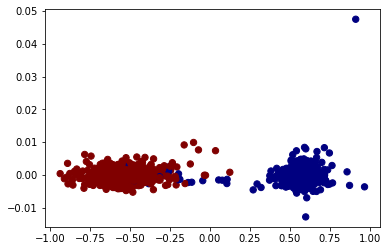

In [22]:
X, ytrue = utils.get_embedding(net, original_test_loader)

pca, Xpca = vis.do_pca(X)
plt.scatter(*(Xpca.T), c = ytrue, s = 40, cmap = 'jet')

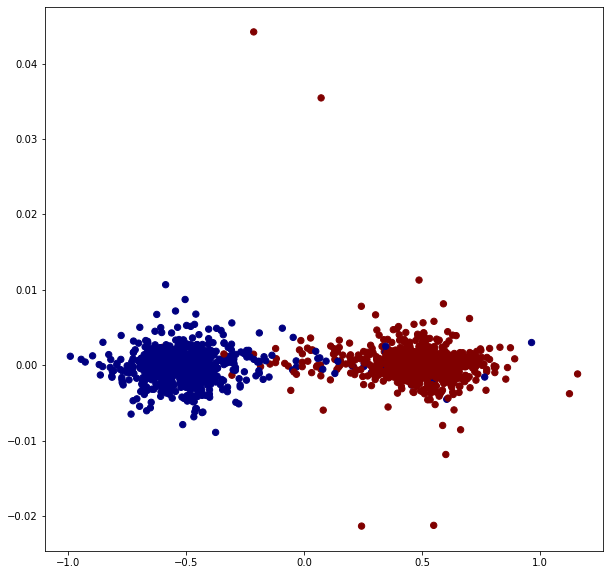

In [483]:
X, ytrue = utils.get_embedding(net, original_test_loader)

pca, Xpca = vis.do_pca(X)
plt.scatter(*(Xpca.T), c = ytrue, s = 40, cmap = 'jet')

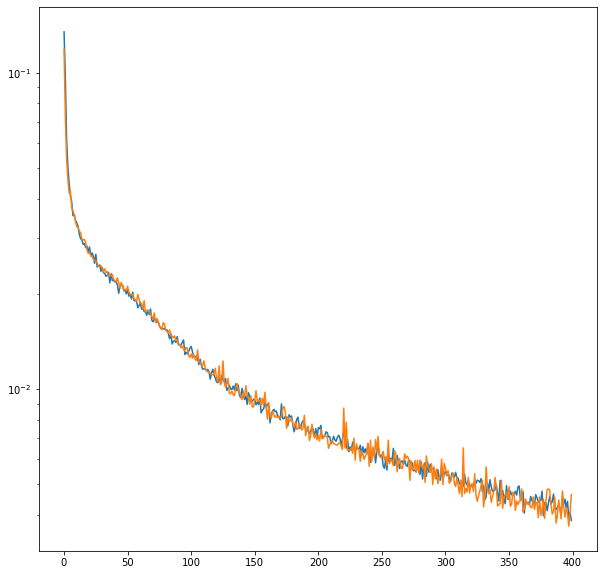

In [86]:
import matplotlib.pyplot as plt
plt.semilogy()
plt.plot(stats_collector['train_loss'])
plt.plot(stats_collector['val_loss'])

In [116]:
qqq = np.repeat(xdu.q_grid, N).reshape(len(xdu.q_grid), N).T

In [120]:
tmp = Ni_cubic_rsample[np.argsort((qqq * Ni_cubic_rsample).sum(axis = 1))]

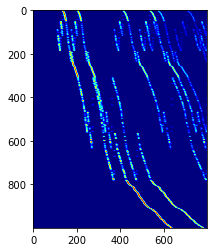

In [123]:
plt.imshow(np.log(1 + tmp), cmap = 'jet')

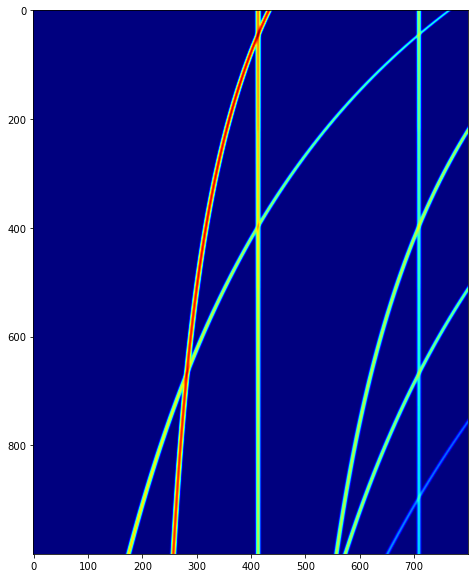

In [89]:
plt.rcParams["figure.figsize"]=(10, 10)

Ni_scan_peaks, Ni_scan = Ni_cubic_to_tetra(1000, .67, 1.5)

plt.imshow(np.log(Ni_scan + 1), cmap = 'jet')

In [170]:
Ni_cub_peaks, Ni_cub_scan = Ni_cubic_scale(1000, .67, 1.5)

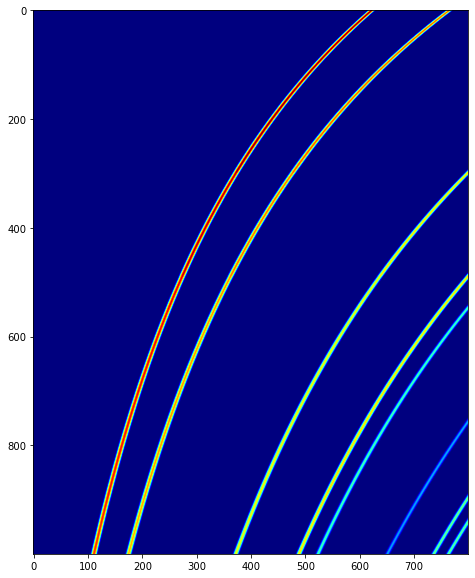

In [173]:
plt.imshow(np.log(Ni_cub_scan + 1), cmap = 'jet')

In [90]:
import numpy as np, cv2
orig = Ni_scan[300:600]
vis = (np.log((1 + orig)) * 40).astype('uint8')
img = gray = cv2.cvtColor(vis, cv2.COLOR_GRAY2BGR)

edges = cv2.Canny(gray,50,150,apertureSize = 3)

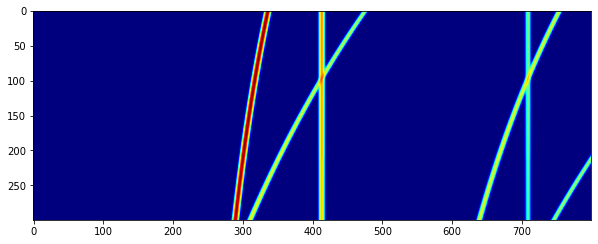

In [91]:
plt.imshow(np.log(1 + orig), cmap = 'jet')

In [712]:
# lines = cv2.HoughLines(edges,1,np.pi/45,70)
# for row in lines:
#     for rho,theta in row:
#         a = np.cos(theta)
#         b = np.sin(theta)
#         x0 = a*rho
#         y0 = b*rho
#         x1 = int(x0 + 1000*(-b))
#         y1 = int(y0 + 1000*(a))
#         x2 = int(x0 - 1000*(-b))
#         y2 = int(y0 - 1000*(a))

#         cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

In [724]:
from xrdc import grid_data

lines_normed = (lines.squeeze() / lines.squeeze().mean(axis = 0))

lgroups = grid_data.group_by_coord(lines_normed, n_cluster=6)

lines_merged = []
for i in np.unique(lgroups):
    lines_merged.append(lines.squeeze()[lgroups == i].mean(axis = 0))
lines_merged = np.vstack(lines_merged)
assert lgroups.max() == 5

In [809]:
#lines = cv2.HoughLines(edges,1,np.pi/45,70)
lines_img = np.zeros_like(img)

lines_arrs = [np.zeros_like(img) for i in range(len(lines_merged))]

for i, row in enumerate(lines_merged[:, None]):
    for rho,theta in row:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
        cv2.line(lines_img,(x1,y1),(x2,y2),(0,0,255),2)
        cv2.line(lines_arrs[i],(x1,y1),(x2,y2),(0,0,255),2)

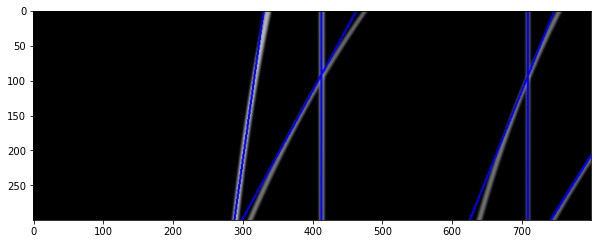

In [730]:
#plt.imshow(np.array(gray))
#plt.imshow(np.array(edges))
plt.imshow(np.array(img))
#plt.imshow(lines_img)

In [767]:
from scipy.signal import convolve2d

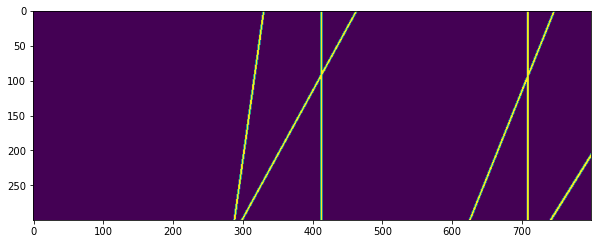

In [778]:
plt.imshow(lines_img.sum(axis = 2))

In [813]:
def row_dp(row, i, refimage):
    return np.dot(refimage[i], row)

In [783]:
c2d = convolve2d(lines_img.sum(axis = 2), Ni_scan[0][:, None])

In [798]:
query = orig[150]
match_curve = np.array([np.dot(r, query) for r in lines_img.sum(axis = 2)])

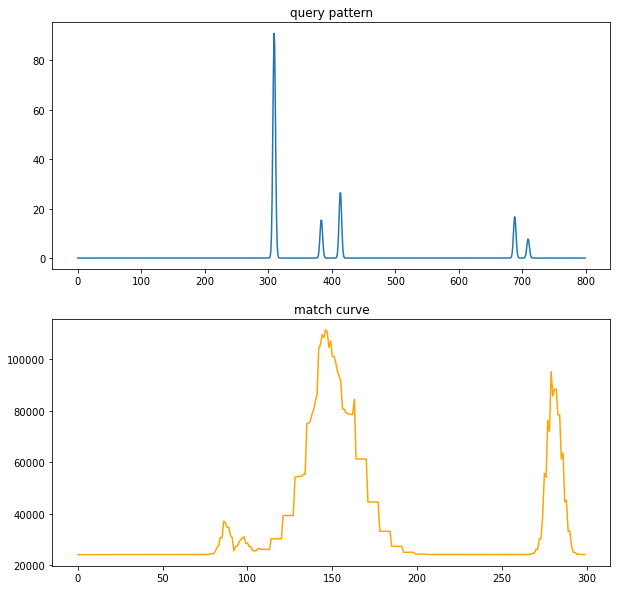

In [863]:
imatch = np.argmax(match_curve)
match = orig[imatch]
plt.subplot(2, 1, 1)
plt.title('query pattern')
plt.plot(query)

plt.subplot(2, 1, 2)
plt.title('match curve')
plt.plot(match_curve, c = 'orange')
# plt.plot(match)

In [818]:
def feats_imatch(imatch):
    return np.array([row_dp(orig[imatch], imatch, lines_arrs[i].sum(axis = 2)) for i in range(len(lines_merged))])

In [826]:
line_feats = np.array([feats_imatch(i) for i in range(len(orig))])

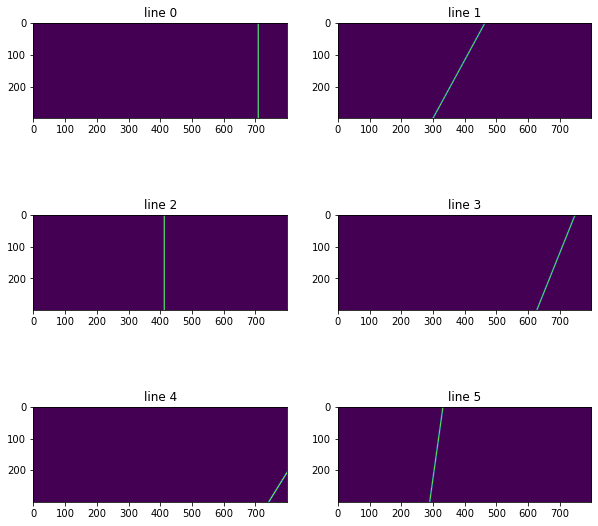

In [850]:
for i in range(len(lines_merged)):
    plt.subplot(3, 2, i + 1)
    plt.title('line {}'.format(i))
    plt.imshow(lines_arrs[i].sum(axis = 2))

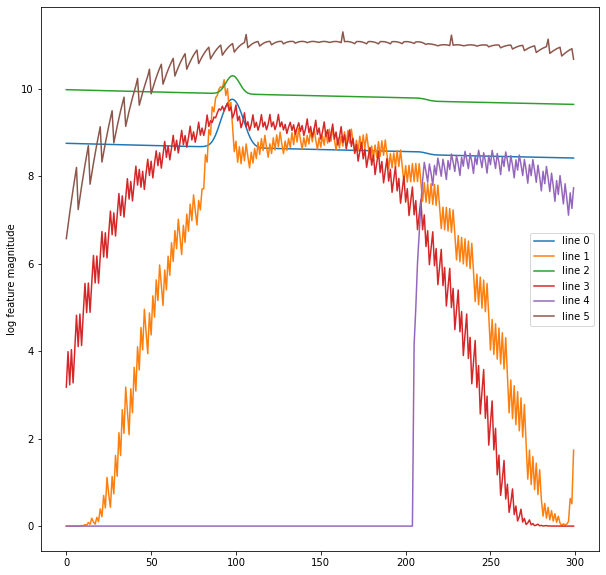

In [837]:
[plt.plot(np.log(1 + row), label = 'line {}'.format(i)) for (i, row) in enumerate(line_feats.T)]
plt.ylabel('log feature magnitude')
plt.legend()

In [765]:
cv2.filter2D(lines_img.sum(axis = 2), -1,  Ni_scan[10]).shape

(300, 800)

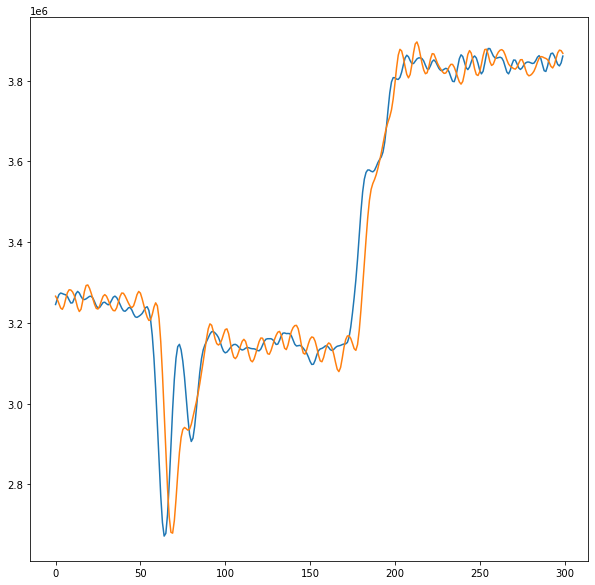

In [764]:
plt.plot(cv2.filter2D(lines_img.sum(axis = 2), -1,  Ni_scan[10]).sum(axis = 1))
plt.plot(cv2.filter2D(lines_img.sum(axis = 2), -1,  Ni_scan[20]).sum(axis = 1))

In [15]:
from importlib import reload
reload(xdu)
reload(grid_data)

<module 'xrdc.xrdutils' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/xrdutils.py'>

In [ ]:
# circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, img.shape[0]/64, param1=200, param2=10, minRadius=500, maxRadius=10000)
# # Draw detected circles
# if circles is not None:
#     circles = np.uint16(np.around(circles))
#     for i in circles[0, :]:
#         # Draw outer circle
#         cv2.circle(img, (i[0], i[1]), i[2], (0, 255, 0), 2)
#         # Draw inner circle
#         cv2.circle(img, (i[0], i[1]), 2, (0, 0, 255), 3)

# alg = cv2.GeneralizedHoughGuil()
# # Simple create template with 1 channel black images with size 5x5
# template = np.zeros((5,5))
# alg.setTemplate(template)

# import cv2
# alg = cv2.createGeneralizedHoughGuil()
# alg.setMinDist(40)
# alg.setLevels(40)

In [13]:
qq, ii = xdu.mk_pattern(i, q, .01, with_grid=True)

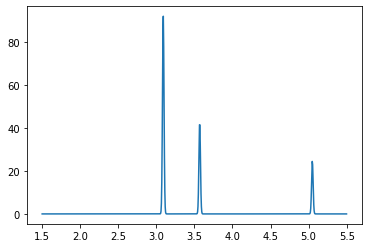

In [14]:
plt.plot(qq, ii)

## Cubic to tetragonal transition:

In [23]:
sigma = .01
q_cubic, i_cubic = distort_Ni(1)
cubic_patterns = np.vstack([xdu.mk_pattern(i_cubic, q_cubic, sigma, with_grid = False)
                           for _ in range(200)])

_, cubic_to_tetra_continuous = Ni_cubic_to_tetra(200, 1, 1.2, sigma = sigma)

In [24]:
from importlib import reload
reload(simulation)

<module 'xrdc.simulation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/simulation.py'>

In [25]:
q_tetra, i_tetra = distort_Ni(1.2)
cubic_to_tetra_twophase = simulation.transition(1, 1, (q, i), (q_tetra, i_tetra), 200, sigma = sigma,
                                                scale_type = 'scale')[::-1]

In [26]:
X = np.vstack((cubic_to_tetra_twophase, cubic_patterns, cubic_to_tetra_continuous))
#X = np.log(1 + np.vstack((cubic_to_tetra_twophase, cubic_patterns, cubic_to_tetra_continuous)))

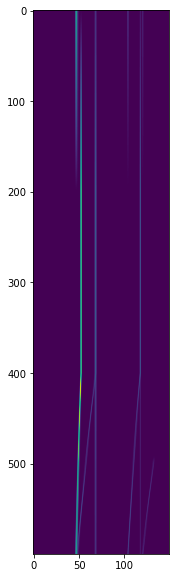

In [585]:
plt.imshow(Ni_X)

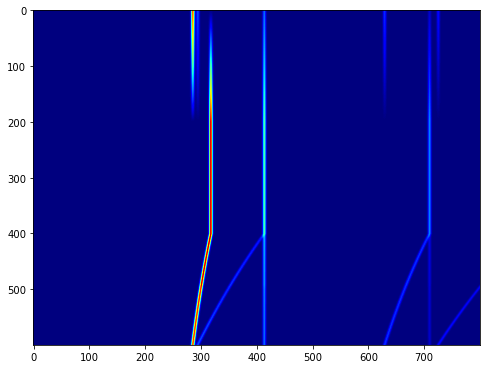

In [43]:
plt.imshow(X, cmap = 'jet')

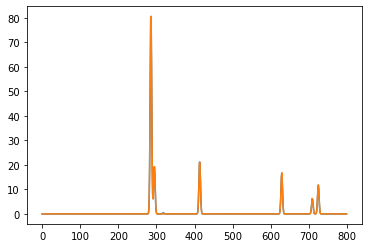

In [28]:
plt.plot(X[0])
plt.plot(X[-1])

In [307]:
Ni_XX, Ni_YY = simulation.sample_transition(X, n_classes = 30, per_class = 200, scale_min = .8, scale_max = 1.2,
                                            scale_type = 'scale')

scale type: scale
q jitter: None
peak height variation True


In [79]:
reload(simulation)

<module 'xrdc.simulation' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/simulation.py'>

In [436]:
Ni_X, Ni_Y = xdu.standardize_input(X, np.arange(len(X)) // 200)

In [229]:
Ni_XX.mean()

1.0

In [230]:
prefix="Ni_cubic_to_tetra"
xdu.write_train_test("data/{}/".format(prefix), Ni_XX, Ni_YY,
                 Ni_XX,\
                 Ni_YY // 10)

In [231]:
runout_Ni_transition =\
    train.run("siamese-constrastive_1d", "XRD", "data/{}/train/".format(prefix), "data/{}/test".format(prefix), name = prefix,
              n_classes = 30, epochs = 200)

  0%|          | 0/37600 [00:00<?, ?it/s, epoch=0, train_loss=0, val_loss=-1]

4
./data/XRD


100%|██████████| 37600/37600 [07:50<00:00, 79.84it/s, epoch=199, train_loss=0.0353, val_loss=0.0353] 


Saving artifacts to ./tmp/siamese-constrastive_1d-XRD-Ni_cubic_to_tetra-*


Legend:

- blue: tetragonal to cubic (discontinuous)
- orange: cubic
- green: cubic to tetragonal (continuous)

siamese-constrastive_1d-XRD-Ni_cubic_to_tetra-testing-set-embedding.png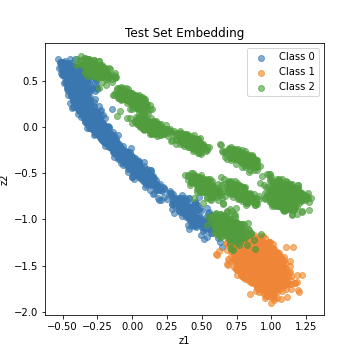

In [271]:
X.shape

(600, 800)

In [29]:
Ni_XX, Ni_YY = simulation.sample_transition(X, n_classes = 3, per_class = 400, scale_min = .8, scale_max = 1.2,
                                            scale_type = 'scale')

#Ni_XX, Ni_YY = xdu.standardize_input(np.log(1 + X), Ni_Y)

scale type: scale
q jitter: None
peak height variation True


In [30]:
Ni_transition_loader = xd.ndarr_to_dataloader(Ni_XX, Ni_YY)

In [241]:
reload(xd)

<module 'xrdc.datasets' from '/Users/ollie/anaconda3/lib/python3.7/site-packages/xrdc-1.0-py3.7.egg/xrdc/datasets.py'>

In [47]:
plt.rcParams["figure.figsize"]=(10, 10)

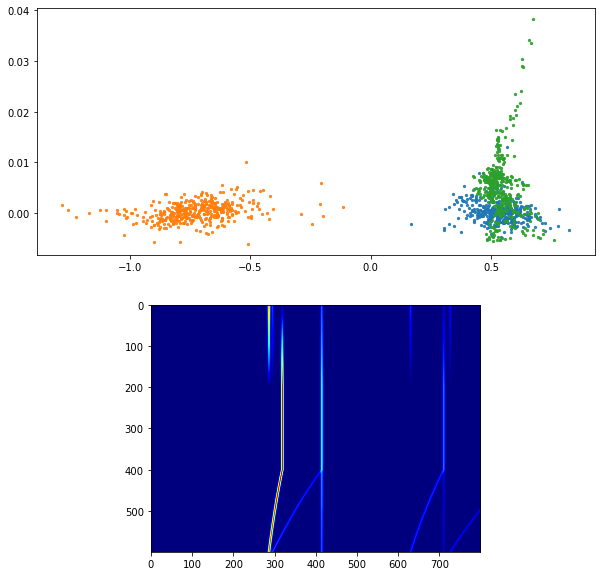

In [85]:
plt.subplot(2, 1, 1)

transition_X, transition_ytrue = utils.get_embedding(net, Ni_transition_loader)

#pca2, transition_Xpca = vis.do_pca(transition_X)
#transition_Xpca, ypred = xdu.gcluster(transition_X, N = 3)

transition_Xpca = pca.transform(transition_X)

#plt.scatter(*(transition_Xpca.T), c = ypred, s = 20, alpha = .3, cmap = 'jet')
for c in range(3):
    plt.scatter(*(((transition_Xpca)[(transition_ytrue == c).squeeze()]).T), s = 5, alpha = .9, cmap = 'jet')
#plt.scatter(*(transition_Xpca.T), c = transition_ytrue, s = 20, alpha = .5, cmap = 'jet')


#plt.scatter(*(Xpca.T), c = ytrue, s = 30, alpha = .5)
#plt.scatter(*(Xpca.T), s = 30, alpha = .5)

plt.subplot(2, 1, 2)
plt.imshow(X, cmap = 'jet')

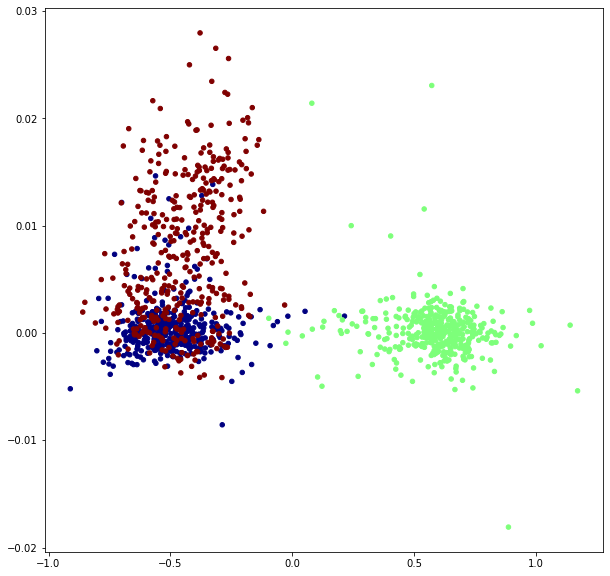

In [484]:
transition_X, transition_ytrue = utils.get_embedding(net, Ni_transition_loader)

#_, transition_Xpca = vis.do_pca(transition_X)

transition_Xpca = pca.transform(transition_X)
plt.scatter(*(transition_Xpca.T), c = transition_ytrue, s = 20, alpha = 1, cmap = 'jet')
#plt.scatter(*(Xpca.T), c = ytrue, s = 30, alpha = .5)
#plt.scatter(*(Xpca.T), s = 30, alpha = .5)